# W207-1 Final Project - "Random Acts of Pizza"

## Team
- Andrew Mamroth
- Colby Carter
- Matt Adereth
- Rob Deng

[Team Github](https://github.com/mamrotha/2017_Fall_207_KaggleProj)

## Overview

[Original Kaggle Description](https://www.kaggle.com/c/random-acts-of-pizza)

There is a sub-reddit called [r/Random_Acts_Of_Pizza](https://www.reddit.com/r/Random_Acts_Of_Pizza/) where users can post requests for someone to purchase them a pizza and, shockingly, random internet strangers will then buy them pizza.  In this competition, we are provided with a data set containing over 5,000 posts from this sub-reddit and our goal is to build a model that can predict whether or not the post will result in a pizza purchase.

# Package Initialization

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# ADD METRICS
from sklearn import metrics
from sklearn.metrics import classification_report

#NLTK - NLP Tokenizing and Cleaning
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#GMM
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [ ]:
# Only evaluate this if you don't already have the NLTK corpora
nltk.download()

# Data 

## Original description of the data from the Kaggle website

This dataset includes 5671 requests collected from the Reddit community Random Acts of Pizza between December 8, 2010 and September 29, 2013 (retrieved on September 30, 2013). All requests ask for the same thing: a free pizza. The outcome of each request -- whether its author received a pizza or not -- is known. Meta-data includes information such as: time of the request, activity of the requester, community-age of the requester, etc.

Each JSON entry corresponds to one request (the first and only request by the requester on Random Acts of Pizza). We have removed fields from the test set which would not be available at the time of posting.

### Field Descriptions

| Field Name | Description |
| ---------- | ----------- |
| giver_username_if_known | Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise). |
| number_of_downvotes_of_request_at_retrieval | Number of downvotes at the time the request was collected. |
| number_of_upvotes_of_request_at_retrieval | Number of upvotes at the time the request was collected. |
| post_was_edited | Boolean indicating whether this post was edited (from Reddit). |
| request_id | Identifier of the post on Reddit, e.g. "t3_w5491". |
| request_number_of_comments_at_retrieval | Number of comments for the request at time of retrieval. |
| request_text | Full text of the request. |
| request_text_edit_aware | Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous". |
| request_title | Title of the request. |
| requester_account_age_in_days_at_request | Account age of requester in days at time of request. |
| requester_account_age_in_days_at_retrieval | Account age of requester in days at time of retrieval. |
| requester_days_since_first_post_on_raop_at_request | Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP). |
| requester_days_since_first_post_on_raop_at_retrieval | Number of days between requesters first post on RAOP and time of retrieval. |
| requester_number_of_comments_at_request | Total number of comments on Reddit by requester at time of request. |
| requester_number_of_comments_at_retrieval | Total number of comments on Reddit by requester at time of retrieval. |
| requester_number_of_comments_in_raop_at_request | Total number of comments in RAOP by requester at time of request. |
| requester_number_of_comments_in_raop_at_retrieval | Total number of comments in RAOP by requester at time of retrieval. |
| requester_number_of_posts_at_request | Total number of posts on Reddit by requester at time of request. |
| requester_number_of_posts_at_retrieval | Total number of posts on Reddit by requester at time of retrieval. |
| requester_number_of_posts_on_raop_at_request | Total number of posts in RAOP by requester at time of request. |
| requester_number_of_posts_on_raop_at_retrieval | Total number of posts in RAOP by requester at time of retrieval. |
| requester_number_of_subreddits_at_request | The number of subreddits in which the author had already posted in at the time of request. |
| requester_received_pizza | Boolean indicating the success of the request, i.e., whether the requester received pizza. |
| requester_subreddits_at_request | The list of subreddits in which the author had already posted in at the time of request. |
| requester_upvotes_minus_downvotes_at_request | Difference of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_minus_downvotes_at_retrieval | Difference of total upvotes and total downvotes of requester at time of retrieval. |
| requester_upvotes_plus_downvotes_at_request | Sum of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_plus_downvotes_at_retrieval | Sum of total upvotes and total downvotes of requester at time of retrieval. |
| requester_user_flair | Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83). |
| requester_username | Reddit username of requester. |
| unix_timestamp_of_request | Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA). |
| unix_timestamp_of_request_utc | Unit timestamp of request in UTC. |

## Initial Loading

In [31]:
# Load raw data and create labels
raw_train = pd.read_json('./data/train.json')
raw_test = pd.read_json('./data/test.json')

print("Raw Train Shape:", raw_train.shape)
print("Raw Test Shape:", raw_test.shape)

Raw Train Shape: (4040, 32)
Raw Test Shape: (1631, 17)


## Schema Reconciliation

The training data has 32 columns, while the test data only has 17.  Let's look at which columns are different:

In [32]:
raw_train_only_columns = set(raw_train.columns.values) - set(raw_test.columns.values)

if len(raw_train_only_columns) > 0:
    print ("Columns in Train but not Test:")
    for c in raw_train_only_columns:
        print (" ", c)
else:
    print ("No columns in Train but not Test")
    
raw_test_only_columns = set(raw_test.columns.values) - set(raw_train.columns.values)
print("")
if len(raw_test_only_columns) > 0:
    print ("Columns in Test but not Train:")
    for c in raw_test_only_columns:
        print (" ", c)
else:
    print ("No columns in Test but not Train")

Columns in Train but not Test:
  number_of_downvotes_of_request_at_retrieval
  requester_days_since_first_post_on_raop_at_retrieval
  number_of_upvotes_of_request_at_retrieval
  post_was_edited
  requester_received_pizza
  requester_number_of_posts_at_retrieval
  requester_user_flair
  request_text
  request_number_of_comments_at_retrieval
  requester_upvotes_plus_downvotes_at_retrieval
  requester_number_of_posts_on_raop_at_retrieval
  requester_number_of_comments_in_raop_at_retrieval
  requester_number_of_comments_at_retrieval
  requester_account_age_in_days_at_retrieval
  requester_upvotes_minus_downvotes_at_retrieval

No columns in Test but not Train


There are several columns that aren't included in the test data and thus need to be excluded from the training data.

- \*_at_retrival - These are features that are dependent on when the data was pulled.  For real-time prediction when a post is made, these are not relevant since they will be the same as their \*_at_request counterparts
- post_was_edited - Since users are supposed to edit their post if they receive a pizza, this would be a major leak of results.  Additionally, we want to be able to make predictions as soon as the post is made, so subsequent edits won't be available.
- requester_user_flair - There isn't historical flair information, so this feature isn't an accurate reflection of the state at the time of the request.  Users who successfully give or receive pizza are granted special flair, so this would also be an unfair indicator of results.
- request_text - Since successful posts are often edited to indicate that the request has been fulfilled, the full request_text can't be used.  The additional "request_text_edit_aware" field has edits stripped out and is available in both the train and test data and will be used instead.

In [33]:
train_with_test_schema = raw_train[raw_test.columns.values]

## Train/Development Data Split

We'll hold out ~15% of the training data as our development data set.  All exploratory data analysis and model training will be done only on the ~85% of training data that is not being held out.  We do not know if the order of the training data is meaningful, so we will use random sampling to avoid introducing bias.

In [34]:
np.random.seed(1)
in_dev = np.random.choice([True, False], len(raw_train), p=[0.15, 0.85])

# train_data will be the training data without any new features added.  This will be used for the EDA.
train_data = train_with_test_schema[np.logical_not(in_dev)].copy()

train_labels = raw_train["requester_received_pizza"][np.logical_not(in_dev)]
dev_labels = raw_train["requester_received_pizza"][in_dev]

# We will add new features to extended_data as we explore.  When we complete, we will set the train_data, dev_data, 
# and test_data to be the appropriate rows from extended_data.
extended_data = pd.concat([train_with_test_schema.copy(), raw_test])
in_train = np.concatenate((np.logical_not(in_dev), np.full(len(raw_test), False)))
in_dev = np.concatenate((in_dev, np.full(len(raw_test), False)))
in_test = np.concatenate((np.full(len(raw_train), False), np.full(len(raw_test), True)))

## Exploratory Data Analysis
We'll now look at the individual fields to understand their types and distributions.

### Request Time
There are several things to look at with respect to the request time:

1. Has the frequency of requests changed over time?
2. Has the rate of request fulfillment changed over time?
3. Does day of week matter? (Possible new feature)
4. Does time of day matter? (Possible new feature)

#### Request Frequency

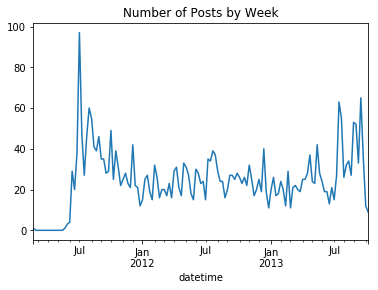

In [35]:
d = pd.DataFrame()
d['datetime'] = pd.to_datetime(train_data["unix_timestamp_of_request"], unit = 's')
d.index = d['datetime']
d['datetime'].resample('W').count().plot().set_title('Number of Posts by Week')

#### Request Fulfillment over Time

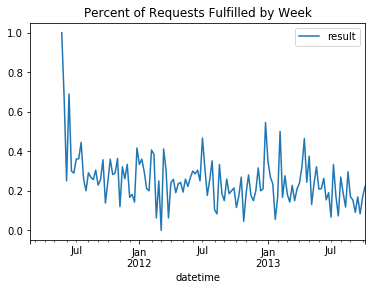

In [36]:
d = pd.DataFrame()
d['datetime'] = pd.to_datetime(train_data["unix_timestamp_of_request"], unit = 's')
d['result'] = train_labels
d.index = d['datetime']
d.resample('W').mean().plot().set_title("Percent of Requests Fulfilled by Week")

It looks like there was a lot of excitement at the start of the sub-reddit.  There was a burst of requests and an unsustained high rate of fulfillment.  We will add a feature that indicates whether or not the post was during this initial time, since it doesn't seem to be a part of the general trend.  August 1st, 2011 looks like a reasonable cutoff, so there will be a new boolean feature called "during_initial_period" that indicates this.

In [37]:
import time
import datetime
cutoff_date = datetime.date(2011,8,1)
cutoff_time = time.mktime(cutoff_date.timetuple())
extended_data['during_initial_period'] = np.where(extended_data['unix_timestamp_of_request_utc'] < cutoff_time, 1, 0)

#### Day of Week

In [38]:
d['dayofweek'] = d['datetime'].dt.dayofweek
d.groupby('dayofweek').agg(['mean', 'count'])

result      
               mean count
dayofweek                
0          0.267894   489
1          0.232246   521
2          0.229167   576
3          0.288503   461
4          0.259825   458
5          0.211111   450
6          0.232323   495

#### Time of Day

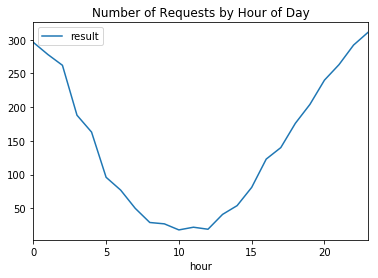

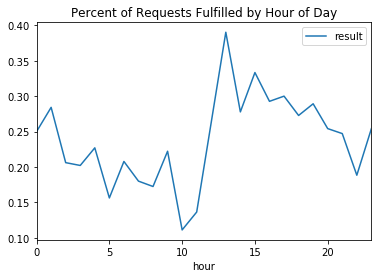

In [39]:
d['hour'] = d['datetime'].dt.hour
d[['hour', 'result']].groupby('hour').agg('count').plot().set_title("Number of Requests by Hour of Day")
d[['hour', 'result']].groupby('hour').agg('mean').plot().set_title("Percent of Requests Fulfilled by Hour of Day")

The fulfillment rate varies from 21.1% to 28.8% by the day of the week and from 11.1% to 39.0% depending on the hour of the day. Both of these seem like reasonably distinguishing features that we should include.

In [40]:
extended_data['day_of_week'] = pd.to_datetime(extended_data["unix_timestamp_of_request"], unit = 's').dt.dayofweek
extended_data['hour_of_day'] = pd.to_datetime(extended_data["unix_timestamp_of_request"], unit = 's').dt.hour

### Field Comparison Utilities

In [41]:
from scipy.stats import ttest_ind

def success_vs_fail_report(feature, try_log = False):
    print (feature)
    success_values = train_data[feature][train_labels]
    print ("SUCCESS", "Mean:", "{:.3f}".format(success_values.mean()), "StdDev:", "{:.3f}".format(success_values.std()))
    fail_values = train_data[feature][np.logical_not(train_labels)]
    print ("FAIL   ", "Mean:", "{:.3f}".format(fail_values.mean()), "StdDev:", "{:.3f}".format(fail_values.std()))
    ttest = ttest_ind(success_values, fail_values, equal_var=False)
    print ("TStat:", "{:.3f}".format(ttest.statistic))
    
    if try_log:
        ttest_of_log = ttest_ind(np.log(success_values + 1), np.log(fail_values + 1), equal_var=False)
        print ("TStat (log):", "{:.3f}".format(ttest_of_log.statistic))
    

### Text Field Lengths
#### Title Length

In [42]:
train_data['title_length'] = train_data['request_title'].str.len()
success_vs_fail_report('title_length', try_log=True)

title_length
SUCCESS Mean: 72.673 StdDev: 36.547
FAIL    Mean: 70.975 StdDev: 36.131
TStat: 1.177
TStat (log): 1.627


#### Request Length

In [43]:
train_data['request_length'] = train_data['request_text_edit_aware'].str.len()
success_vs_fail_report('request_length', try_log=True)

request_length
SUCCESS Mean: 464.468 StdDev: 386.954
FAIL    Mean: 375.359 StdDev: 346.614
TStat: 5.965
TStat (log): 5.934


It seems that the title length doesn't seem to vary much for those who received a pizza vs those that did not.  However, it does appear that a longer request is much more likely to get you a pizza.  This is a very good feature to include in the model.

In [44]:
extended_data['request_length'] = extended_data['request_text_edit_aware'].str.len()

### Upvotes vs Downvotes

Here we compare using the features requester_upvotes_minus_downvotes_at_request and requester_upvotes_plus_downvotes_at_request vs creating new features 'upvotes' and 'downvotes'

In [45]:
success_vs_fail_report('requester_upvotes_minus_downvotes_at_request')  #Not doing log because this can be negative

print()
success_vs_fail_report('requester_upvotes_plus_downvotes_at_request', try_log=True)

print()
train_data['upvotes']  = (train_data['requester_upvotes_minus_downvotes_at_request'] +
                       train_data['requester_upvotes_plus_downvotes_at_request']) / 2
success_vs_fail_report('upvotes', try_log=True)

print()
train_data['downvotes']  = (train_data['requester_upvotes_plus_downvotes_at_request'] +
                       train_data['upvotes'])
success_vs_fail_report('downvotes', try_log=True)

print()
train_data['upvotes_ratio']  = np.nan_to_num(train_data['upvotes'] / train_data['requester_upvotes_plus_downvotes_at_request'], 0)
success_vs_fail_report('upvotes_ratio')

requester_upvotes_minus_downvotes_at_request
SUCCESS Mean: 1373.866 StdDev: 5750.130
FAIL    Mean: 1091.154 StdDev: 3032.528
TStat: 1.370

requester_upvotes_plus_downvotes_at_request
SUCCESS Mean: 4913.838 StdDev: 45155.115
FAIL    Mean: 3388.588 StdDev: 18429.577
TStat: 0.957
TStat (log): 6.320

upvotes
SUCCESS Mean: 3143.852 StdDev: 25375.832
FAIL    Mean: 2239.871 StdDev: 10555.068
TStat: 1.008
TStat (log): 6.375

downvotes
SUCCESS Mean: 8057.690 StdDev: 70524.770
FAIL    Mean: 5628.459 StdDev: 28967.296
TStat: 0.975
TStat (log): 6.454

upvotes_ratio
SUCCESS Mean: 0.665 StdDev: 0.263
FAIL    Mean: 0.600 StdDev: 0.315
TStat: 5.892


Both the upvotes_ratio and log(upvotes + 1) are very strong indicators, so they should also be included as a new feature.

In [46]:
extended_data['upvotes'] = (extended_data['requester_upvotes_minus_downvotes_at_request'] +
                            extended_data['requester_upvotes_plus_downvotes_at_request']) / 2

extended_data['upvotes_log'] = np.log(extended_data['upvotes'] + 1)

extended_data['upvotes_ratio'] = np.nan_to_num(
   (extended_data['upvotes'] / extended_data['requester_upvotes_plus_downvotes_at_request']), 0)

### Requestor Activity

In [47]:
success_vs_fail_report('requester_number_of_posts_at_request', try_log=True)
print()
success_vs_fail_report('requester_number_of_posts_on_raop_at_request', try_log=True)
print()
success_vs_fail_report('requester_account_age_in_days_at_request', try_log=True)
print()
success_vs_fail_report('requester_number_of_subreddits_at_request', try_log=True)

requester_number_of_posts_at_request
SUCCESS Mean: 24.457 StdDev: 55.193
FAIL    Mean: 21.011 StdDev: 50.562
TStat: 1.610
TStat (log): 3.372

requester_number_of_posts_on_raop_at_request
SUCCESS Mean: 0.128 StdDev: 0.492
FAIL    Mean: 0.037 StdDev: 0.216
TStat: 5.189
TStat (log): 5.356

requester_account_age_in_days_at_request
SUCCESS Mean: 277.821 StdDev: 306.417
FAIL    Mean: 250.212 StdDev: 302.220
TStat: 2.284
TStat (log): 5.496

requester_number_of_subreddits_at_request
SUCCESS Mean: 19.930 StdDev: 21.806
FAIL    Mean: 17.660 StdDev: 21.698
TStat: 2.634
TStat (log): 5.184


In [48]:
extended_data['requester_number_of_posts_at_request_log'] = np.log(extended_data['requester_number_of_posts_at_request'] + 1)
extended_data['requester_account_age_in_days_at_request_log'] = np.log(extended_data['requester_account_age_in_days_at_request'] + 1)
extended_data['requester_number_of_subreddits_at_request_log'] = np.log(extended_data['requester_number_of_subreddits_at_request'] + 1)

#### First Time Posting
We see that the number of posts on r/raop is likely a good indicator.  What about just seeing if this being the first time someone posts is significant?

In [49]:
train_data['first_raop_post'] = train_data['requester_number_of_posts_on_raop_at_request'] == 0
success_vs_fail_report('first_raop_post')

print()
print ("Success Rate if First Post:", train_labels[train_data['first_raop_post']].mean())
print ("Success Rate if Not First Post:", train_labels[np.logical_not(train_data['first_raop_post'])].mean())

first_raop_post
SUCCESS Mean: 0.916 StdDev: 0.277
FAIL    Mean: 0.968 StdDev: 0.177
TStat: -5.091

Success Rate if First Post: 0.235204855842
Success Rate if Not First Post: 0.458064516129


We can see that the success rate is much higher if this is not the users first time posting on the subreddit.  This is likely a stong feature to add.

In [50]:
extended_data['first_raop_post'] = extended_data['requester_number_of_posts_on_raop_at_request'] == 0

### Text Analysis
#### Magic Words: Please vs Need
As a warm up, let's investigate the hypothesis that being polite makes a difference.

In [51]:
train_data['says_please'] = train_data['request_text_edit_aware'].str.lower().str.contains("please")
success_vs_fail_report('says_please')

train_data['says_need'] = train_data['request_text_edit_aware'].str.lower().str.contains("need")
success_vs_fail_report('says_need')

says_please
SUCCESS Mean: 0.084 StdDev: 0.277
FAIL    Mean: 0.098 StdDev: 0.297
TStat: -1.219
says_need
SUCCESS Mean: 0.165 StdDev: 0.372
FAIL    Mean: 0.125 StdDev: 0.331
TStat: 2.811


Here we see that the magic word isn't so magic, but all is not lost.  It seems people in need are more likely to get a pizza.  The NLTK transformations will take care of collecting these features but still nice to check.

#### Vectorizing Request Titles & Text
We believe that the titles and request body should be treated separately.

In [52]:
request_text_vectorizer = Pipeline([('cv', CountVectorizer()),
                                    ('tfidf', TfidfTransformer())])
train_request_text_wordvecs = request_text_vectorizer.fit_transform(train_data['request_text_edit_aware'])

request_title_vectorizer = Pipeline([('cv', CountVectorizer()),
                                    ('tfidf', TfidfTransformer())])
train_request_title_wordvecs = request_title_vectorizer.fit_transform(train_data['request_title'])

print ("Request Text Shape:", train_request_text_wordvecs.shape)
print ("Request Title Shape:", train_request_title_wordvecs.shape)

extended_request_text_wordvecs = request_text_vectorizer.transform(extended_data['request_text_edit_aware'])
extended_request_title_wordvecs = request_title_vectorizer.transform(extended_data['request_title'])

Request Text Shape: (3450, 11311)
Request Title Shape: (3450, 4072)


With 11311 unique words for the request text and 4072 unique words for the request title, this may prove to be an unreasonably large number of features for some models.  For the models that can deal with huge dimensions, we will provide the original word vectors.  For models that can't handle this, we will perform dimensionality reduction using PCA.

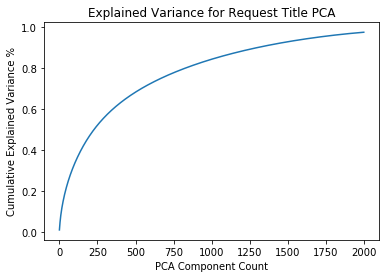

In [53]:
title_pca = PCA(2000)
title_pca.fit(train_request_title_wordvecs.todense())
plt.plot(np.cumsum(title_pca.explained_variance_ratio_))
plt.xlabel('PCA Component Count')
plt.ylabel('Cumulative Explained Variance %')
plt.title('Explained Variance for Request Title PCA')
plt.show()


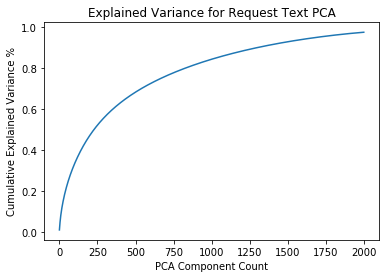

In [54]:
text_pca = PCA(2000)
text_pca.fit(train_request_title_wordvecs.todense())
np.cumsum(text_pca.explained_variance_ratio_)

plt.plot(np.cumsum(text_pca.explained_variance_ratio_))
plt.xlabel('PCA Component Count')
plt.ylabel('Cumulative Explained Variance %')
plt.title('Explained Variance for Request Text PCA')
plt.show()

## Final Data Preparation
Now that we've done all our transformations on the "extended" data set, we will split it back up into train, dev, and test.

In [70]:
train_data = extended_data[in_train]
dev_data = extended_data[in_dev]
test_data = extended_data[in_test]

### Numeric Features to Use

In [56]:
features = [
    'day_of_week',
    'hour_of_day',
    'request_length',
    'upvotes_log',
    'upvotes_ratio',
    'requester_number_of_posts_on_raop_at_request',
    'requester_number_of_posts_at_request_log',
    'requester_account_age_in_days_at_request_log',
    'requester_number_of_subreddits_at_request_log',
    'first_raop_post'
]

# Modeling

Logistic with c = 0.0001 and l2 regularization:
train ROC: 0.584
dev ROC:   0.618

******************************

Logistic with c = 0.001 and l2 regularization:
train ROC: 0.607
dev ROC:   0.642

******************************

Logistic with c = 0.005 and l2 regularization:
train ROC: 0.625
dev ROC:   0.667

******************************

Logistic with c = 0.01 and l2 regularization:
train ROC: 0.628
dev ROC:   0.671

******************************

Logistic with c = 0.025 and l2 regularization:
train ROC: 0.629
dev ROC:   0.674

******************************

Logistic with c = 0.05 and l2 regularization:
train ROC: 0.629
dev ROC:   0.674

******************************

Logistic with c = 0.1 and l2 regularization:
train ROC: 0.629
dev ROC:   0.675

******************************

Logistic with c = 0.125 and l2 regularization:
train ROC: 0.629
dev ROC:   0.674

******************************

Logistic with c = 0.25 and l2 regularization:
train ROC: 0.629
dev ROC:   0.675

**********

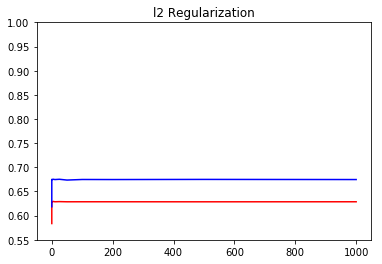

Logistic with c = 0.0001 and l1 regularization:
train ROC: 0.591
dev ROC:   0.629

******************************

Logistic with c = 0.001 and l1 regularization:
train ROC: 0.591
dev ROC:   0.629

******************************

Logistic with c = 0.005 and l1 regularization:
train ROC: 0.582
dev ROC:   0.610

******************************

Logistic with c = 0.01 and l1 regularization:
train ROC: 0.595
dev ROC:   0.623

******************************

Logistic with c = 0.025 and l1 regularization:
train ROC: 0.627
dev ROC:   0.662

******************************

Logistic with c = 0.05 and l1 regularization:
train ROC: 0.629
dev ROC:   0.668

******************************

Logistic with c = 0.1 and l1 regularization:
train ROC: 0.629
dev ROC:   0.671

******************************

Logistic with c = 0.125 and l1 regularization:
train ROC: 0.629
dev ROC:   0.672

******************************

Logistic with c = 0.25 and l1 regularization:
train ROC: 0.629
dev ROC:   0.674

**********

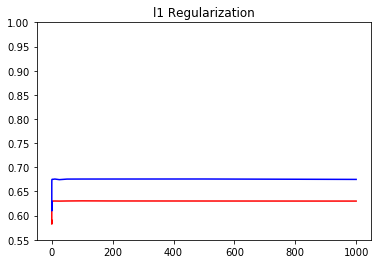

Best development ROC: 0.676 (c= 500 , reg= l1 )


In [71]:
def logistic_tester(c=1, p="l2", 
                    train_data = train_data[features],
                    train_labels = train_labels,
                    dev_data = dev_data[features],
                    dev_labels = dev_labels,
                    test_data = test_data[features]):
    """Train logistic for any C, penalty; return ROC score on development set and test set predictions"""
    
    print("Logistic with c =", str(c), "and", p,"regularization:")
    full_lr = LogisticRegression(penalty=p, C=c, tol=.001, class_weight="balanced")
    full_lr.fit(train_data, train_labels)

    train_preds = full_lr.predict(train_data)
    train_probs = full_lr.predict_proba(train_data)
    train_ROC = metrics.roc_auc_score(train_labels, train_probs[:,1])

    dev_preds = full_lr.predict(dev_data)
    dev_probs = full_lr.predict_proba(dev_data)
    dev_ROC = metrics.roc_auc_score(dev_labels, dev_probs[:,1])

    test_preds = full_lr.predict(test_data)

    print("train ROC:", "{:.3f}".format(train_ROC))
    print("dev ROC:  ", "{:.3f}".format(dev_ROC))

    #print("For train:\n", classification_report(train_preds, train_labels))
    #print("For dev:\n", classification_report(dev_preds, dev_labels))
    
    print("\n"+"*"*30+"\n")
    return train_ROC, dev_ROC, test_preds


c_list = [.0001, .001, .005, .01, .025, .05, .1, .125, .25, .5, 1, 5, 10, 25, 50, 100, 200, 500, 1000]
reg = ["l2","l1"]

best_dev_roc = 0

for r in reg:
    train_scores = []
    dev_scores = []
    for c in c_list:
        train_ROC, dev_ROC, test_out = logistic_tester(c=c, p=r)
        if (dev_ROC > best_dev_roc):
            best_dev_roc = dev_ROC
            test_preds = test_out
            best_c = c
            best_reg = r
        train_scores.append(train_ROC)
        dev_scores.append(dev_ROC)
    plt.plot(c_list, train_scores, "r", c_list, dev_scores, "b")
    plt.title(r+" Regularization")
    plt.ylim(.55,1)
    plt.show()

print("Best development ROC:", "{:.3f}".format(best_dev_roc), "(c=", best_c,", reg=", best_reg, ")")


def export_test_preds(test_preds, test_data = test_data):
    test_out = pd.DataFrame()
    test_out['request_id'] = test_data['request_id']
    test_out['requester_received_pizza'] = test_preds.astype(int)
    test_out.to_csv('./data/submissionX.csv', index=False)
    return None

export_test_preds(test_preds)

## [old]

In [96]:
#Rob's Section

#Preprocess
def nltk_preprocess(data):
    stop = stopwords.words('english')
    
    #Merge title and request text together, lower string
    data['title_and_request'] = data[['request_text_edit_aware', 'request_title']].apply(lambda x: ''.join(x), axis=1).str.lower()
    #replacing sequences of numbers with a single token, removing various other non-letter characters, removing strings with underscores
    data['title_and_request'] = data['title_and_request'].apply(lambda x: re.sub(r'\d+', r' ', x)).apply(lambda y: re.sub(r'\W+', r' ', y)).apply(lambda z: re.sub(r"_+",r" ",z))
    #NLTK Tokenize
    data['tokenized_requests'] = data['title_and_request'].apply(word_tokenize)
    #NLTK Remove Stop Words i.e. the, an, etc
    data['tokenized_requests'] = data['tokenized_requests'].apply(lambda x: [item for item in x if item not in stop])
    #Word count of leftovers; didn't use this yet
    data['word_count'] = [len(data['tokenized_requests'][i]) for i in range(data.index[0], data.index[-1]+1)]
    #Rejoin after str split
    data['tokenized_requests'] = data['tokenized_requests'].apply(lambda x: ' '.join(x))
    return data['tokenized_requests']


def classify(model, model_parameters = False, use_tfidf=False):
    """Takes a model and parameters. 
       Outputs a classification report on the dev data, scored by f1_weighted.
       Prints out the best gridsearch parameter of choice."""
    if(use_tfidf):
        pipeliner = Pipeline([('cv', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('model', model())])
    else:
        pipeliner = Pipeline([("cv", CountVectorizer()), 
                              ("model", model())])

        #Make a simple prediction
    pipeliner.fit(processed_mini_train_data, mini_train_labels)
    pipeliner_pred = pipeliner.predict(processed_dev_data)
    print(model, "\n\n", "TFIDF = ", use_tfidf, "\n")
    print(classification_report(pipeliner_pred, dev_labels))
    return None


#process text entries
processed_mini_train_data = nltk_preprocess(mini_train_data)
processed_dev_data = nltk_preprocess(dev_data)
processed_test_data = nltk_preprocess(test_data)

classify(MultinomialNB, model_parameters = {"model__analyzer":"word", "model__ngram_range":(1,2)}, use_tfidf = True)
classify(MultinomialNB, model_parameters = {"model__analyzer":"word", "model__ngram_range":(1,2)}, use_tfidf = False)
classify(LogisticRegression, use_tfidf = True)
classify(LogisticRegression, use_tfidf = False)

C:\Users\madereth\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\madereth\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\madereth\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

KeyError: 620L

In [ ]:
# Explore terms with the largest coefficients

def classify2(model, model_parameters = False, use_tfidf=False):
    """Takes a model and parameters. 
       Outputs a classification report on the dev data, scored by f1_weighted.
       Prints out the best gridsearch parameter of choice."""
    vec = CountVectorizer()
    train_feats = vec.fit_transform(processed_mini_train_data)
    train_vocab = vec.get_feature_names()
    print(len(train_vocab))
    dev_feats = vec.transform(processed_dev_data)
    
    lr =  LogisticRegression()
    #lr =  LogisticRegression(penalty="l1")
    lr.fit(train_feats, mini_train_labels)
    lr_preds = lr.predict(dev_feats)
    print(metrics.f1_score(dev_labels, lr_preds, average='micro'))
    print(classification_report(lr_preds, dev_labels))

    coefs = lr.coef_
    #print(coefs.shape)
    max_coefs = np.argsort(coefs, axis=1)[:,-30:]
    #print(max_coefs)
    top_features = []
    for i in range(max_coefs.shape[1]):
        #print(max_coefs[0][i])
        print(train_vocab[max_coefs[0][i]])


classify2(LogisticRegression, use_tfidf = False)

In [ ]:
#join numeric and vocabulary features

#use preprocessed vocab features
vec_full = CountVectorizer(stop_words = "english")
train_feats = vec_full.fit_transform(processed_mini_train_data)
train_vocab = vec_full.get_feature_names()
dev_feats = vec_full.transform(processed_dev_data)
test_feats = vec_full.transform(processed_test_data)

#make vocab arrays
train_vocab_ar = train_feats.toarray()
dev_vocab_ar = dev_feats.toarray()
test_vocab_ar = test_feats.toarray()
#new_array = np.array(train_feats)
print("Vocab train:", train_vocab_ar.shape)

#make numeric arrays
train_num_ar = mini_train_data[num_columns].as_matrix()
dev_num_ar = dev_data[num_columns].as_matrix()
test_num_ar = test_data[num_columns].as_matrix()
print("Numeric train:",train_num_ar.shape)

#join arrays into final feature sets
combined_train_feats = np.concatenate((train_vocab_ar,train_num_ar), axis = 1)
combined_dev_feats = np.concatenate((dev_vocab_ar,dev_num_ar), axis = 1)
combined_test_feats = np.concatenate((test_vocab_ar,test_num_ar), axis = 1)
print("Combined:",combined_train_feats.shape)
print("Test:",combined_test_feats.shape)

In [ ]:
#Build a logistic model based on number value columns + preprocessed text field
# test with various values for C
full_lr = LogisticRegression(penalty="l1", C = .5)
full_lr.fit(combined_train_feats, mini_train_labels)
#full_lr.fit(train_feats, mini_train_labels)

#print(full_lr.coef_[0:20])

dev_preds = full_lr.predict(combined_dev_feats)
test_preds = full_lr.predict(combined_test_feats)
#dev_preds = full_lr.predict(dev_feats)
print(metrics.f1_score(dev_labels, dev_preds, average='micro'))
print(classification_report(dev_preds, dev_labels))

#test_preds = full_lr.predict(combined_test_feats)

test_out = pd.DataFrame()
test_out['request_id'] = test_data['request_id']
test_out['requester_received_pizza'] = test_preds.astype(int)
#num = sum(preds['requester_received_pizza'])

#print(num, sum(train_labels))

test_out.to_csv('./data/submission2.csv', index=False)

## GMM and PCA

In [ ]:
feat_nums = list(range(4,13))
train_nums = train_data[feat_nums]

names = train_nums.columns.values
for i in names:
    plt.title(i)
    plt.hist(train_nums[i])
    plt.show()

In [ ]:
exp_var = []

#Cycle through 50 iterations of PCA
for i in range(1,21):
    
    pca = PCA(n_components=i)
    pca.fit(train_num_ar)

#Grab the coefs of the explained variance, sum them and put them on the list to graph
    coefs = pca.explained_variance_ratio_
    tot = sum(coefs)
    exp_var.append(tot)

#Create the graph using the exp_var list
x = range(1,21)
y = exp_var
plt.plot(x,y,'b')
plt.title('Variance Explained by the First k Components')
plt.ylabel('Explained Variance')
plt.xlabel('Number of Principal Components')
plt.show()